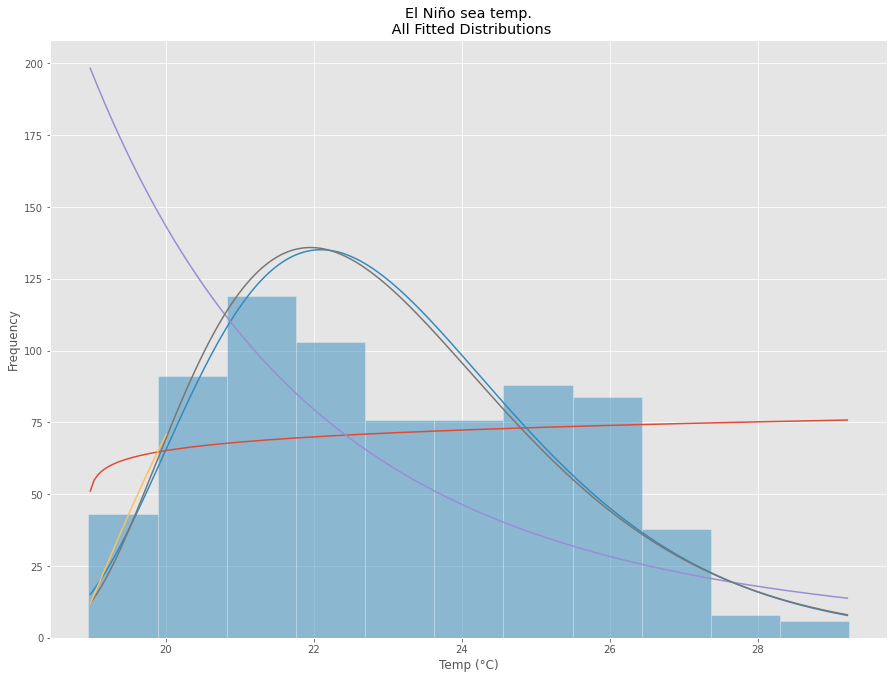

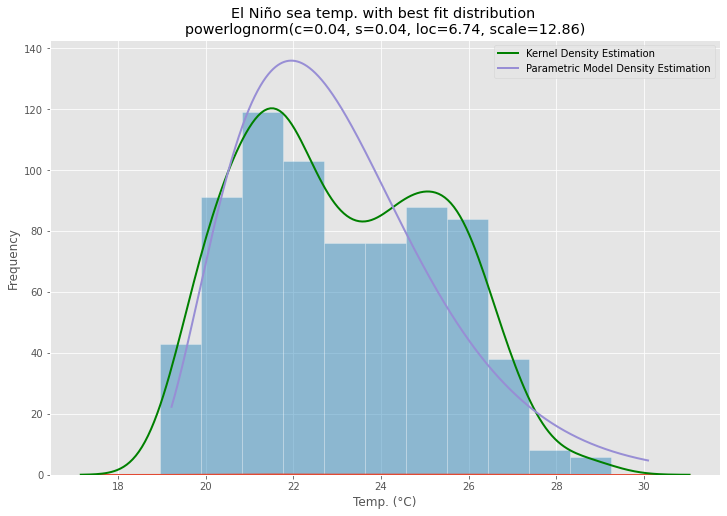

In [640]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    
    RELEVANT_D = [        
        st.powerlaw,st.gamma,st.pareto,st.powerlognorm,st.powernorm]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in RELEVANT_D:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf*data.value_counts().sum(), x).plot(ax=ax)
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


bins = min(freedman_diaconis_rule(data),50)

# Load data from statsmodels datasets
data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(15,11))
ax = data.plot(kind='hist', bins=bins, alpha=0.5,color=list(plt.rcParams['axes.prop_cycle'])[1]['color'],
              ec='white')

# Save plot limits


# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display

plt.figure(figsize=(12,8))


p = sns.kdeplot(data)
kde = pd.Series(p.get_lines()[0].get_data()[1],p.get_lines()[0].get_data()[0])

plt.hist(data,alpha=0.5,bins=bins,ec='white')
plt.plot(kde*data.value_counts().sum(),lw=2, label='Kernel Density Estimation',color='g')
plt.plot(pdf*data.value_counts().sum(),lw=2, label='Parametric Model Density Estimation')
plt.ylabel('Count')
plt.xlabel('Scores')
plt.legend()

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

plt.title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
plt.xlabel(u'Temp. (°C)')
plt.ylabel('Frequency')

plt.legend()

<Figure size 864x576 with 0 Axes>

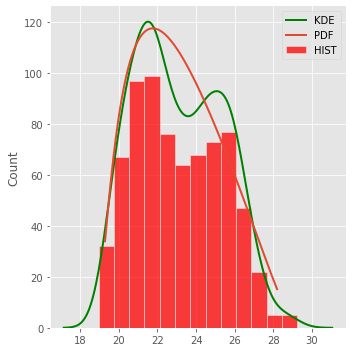

In [7]:
plt.figure(figsize=(12,8))
sns.displot(data,legend=True, color='r',label='HIST')
plt.plot(kde*data.value_counts().sum(),lw=2, label='KDE',color='g')
plt.plot(pdf*data.value_counts().sum(),lw=2, label='PDF')
plt.legend()

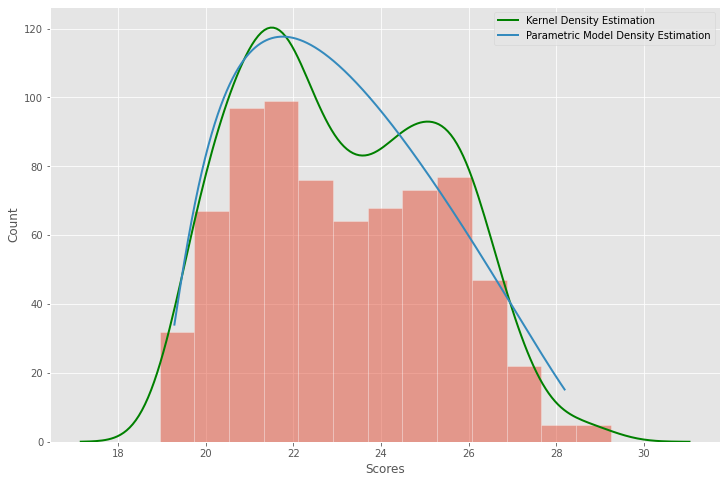

In [16]:
plt.figure(figsize=(12,8))
bins = min(freedman_diaconis_rule(data),50)
plt.hist(data,alpha=0.5,bins=bins,ec='white')
plt.plot(kde*data.value_counts().sum(),lw=2, label='Kernel Density Estimation',color='g')
plt.plot(pdf*data.value_counts().sum(),lw=2, label='Parametric Model Density Estimation')
plt.ylabel('Count')
plt.xlabel('Scores')
plt.legend()

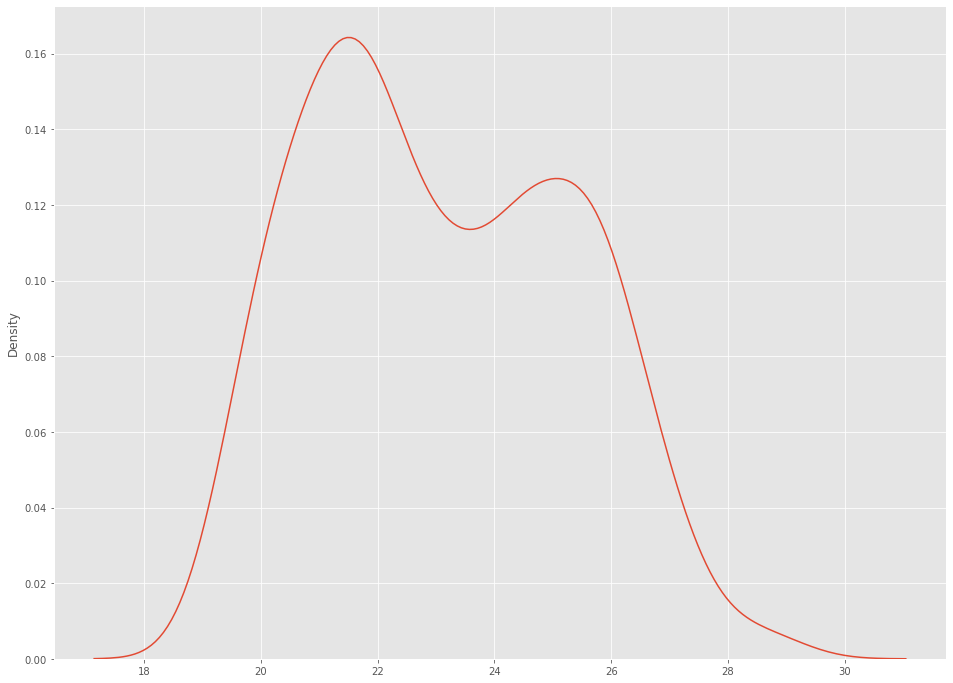

In [3]:
p = sns.kdeplot(data)
kde = pd.Series(p.get_lines()[0].get_data()[1],p.get_lines()[0].get_data()[0])

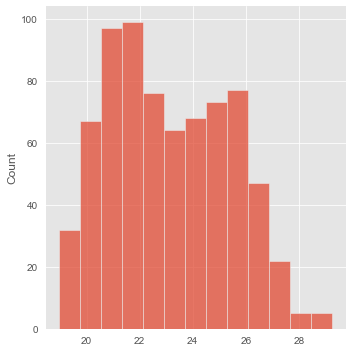

In [123]:
h = sns.displot(data)

In [5]:
len(kde)

200

In [18]:
np.histogram(data)

(array([ 50, 103, 133,  98,  81,  99,  97,  54,  10,   7], dtype=int64),
 array([18.95 , 19.979, 21.008, 22.037, 23.066, 24.095, 25.124, 26.153,
        27.182, 28.211, 29.24 ]))

In [19]:
y, x = np.histogram(data, bins=bins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

In [20]:
x

array([19.34576923, 20.13730769, 20.92884615, 21.72038462, 22.51192308,
       23.30346154, 24.095     , 24.88653846, 25.67807692, 26.46961538,
       27.26115385, 28.05269231, 28.84423077])

In [126]:
bins = min(len(np.histogram_bin_edges(data, bins="fd")), 50)

In [127]:
bins

14

In [135]:
import scipy.stats as stats
def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))
    
def iqr(a):
    """Calculate the IQR for an array of numbers."""
    a = np.asarray(a)
    q1 = np.percentile(a, 25)
    q3 = np.percentile(a, 75)
    return q3 - q1

In [136]:
min(_freedman_diaconis_bins(data), 50)

13

In [639]:
def freedman_diaconis_rule(data):
    a = np.array(data)
    if len(data) <2:
        return 1
    h = 2*(np.percentile(data,75)-np.percentile(data,25))*len(data)**(-1/3)

    if h==0:
        return len(data)
    else:
        return int(np.ceil((max(data)-min(data))/h))

In [10]:
min(freedman_diaconis_rule(data),50)

13

In [90]:
lines[0]

In [65]:
pdf 

19.285664    0.046485
19.286555    0.046588
19.287445    0.046691
19.288336    0.046793
19.289227    0.046896
               ...   
28.187603    0.020846
28.188494    0.020823
28.189384    0.020800
28.190275    0.020778
28.191166    0.020755
Length: 10000, dtype: float64

In [66]:
pdf * 732

19.285664    34.027354
19.286555    34.102423
19.287445    34.177478
19.288336    34.252520
19.289227    34.327548
               ...    
28.187603    15.259245
28.188494    15.242583
28.189384    15.225924
28.190275    15.209270
28.191166    15.192620
Length: 10000, dtype: float64

In [61]:
sum(data.value_counts().values)

732

In [28]:
pdf.values

array([0.04648546, 0.04658801, 0.04669054, ..., 0.02080044, 0.02077769,
       0.02075495])

###  Theorical Discriminative Score Distribution

In [36]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf



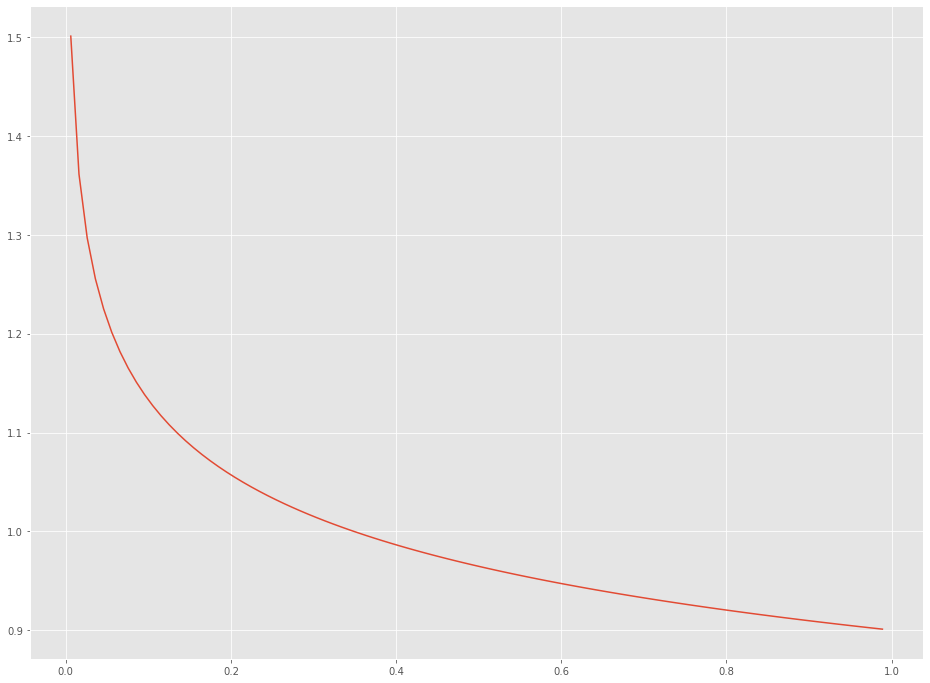

In [70]:
from scipy.stats import powerlaw

a = 0.9

x = np.linspace(powerlaw.ppf(0.01,a),powerlaw.ppf(0.99,a),100)

plt.plot(x,powerlaw.pdf(x,a))

###### Shape parameter $\alpha$ has to be such that $\alpha<1$ in order to get a discrimitative distribution that suit our use-case : a few highly scored keywords that seperate from the rest in a pyramidal pattern ( the majority of candidate keywords have low scores, the higher the score their rarity

### Test of this theoritical framework with actual transformed scores

In [71]:
import yake
from keybert import KeyBERT
from sklearn.metrics.pairwise import cosine_similarity
from keybert.backend._utils import select_backend
import numpy as np
import pandas as pd


class KeyBoost:

    def __init__(self,
    transformers_model,
    ):
        self.transformers_model = transformers_model


    def extract_keywords(self,
                        text,
                        language,
                        n_top,
                        keyphrases_ngram_max,
                        consensus,
                        stopwords=None):
        # YAKE extraction

        yk_rank = yake_extraction(text,
                            language,
                            keyphrases_ngram_max,
                            n_top,
                            stopwords)

        # KeyBERT extraction
        kb_rank = keybert_extraction(text,
                              keyphrases_ngram_max,
                              n_top,
                              stopwords,
                              transformers_model=self.transformers_model)
        # Extract scores

        if  consensus   == 'statistical':

            keywords = statistical_consensus(scores=[yk_rank,kb_rank],
                                  n_top=n_top,
                                  transformers_model='distilbert-base-nli-mean-tokens')
            
        elif consensus == 'rank':

            keywords =  rank_consensus(scores=[yk_rank,kb_rank],n_top=n_top)


        return keywords

def extract_rank(scores):

    key_rank = pd.concat(scores,axis=0).sort_values(by='Score',ascending=False)
    key_rank.index = range(len(key_rank))
    key_rank['Score'] = key_rank['Score'] + -key_rank['Score'].min()

    return  key_rank



def deduplication(key_rank,n_top,transformers_model,tresh=0.9):
  model = select_backend(transformers_model)

  keywords = [(key_rank.values[0][0],key_rank.values[0][1])]

  for row in key_rank.values:
    skip=False
    for k in keywords:
      sim = cosine_similarity([model.embed(row[0])],[model.embed(k[0])])[0][0]
      #print((k,row[0]),sim)
      if sim > tresh:
        skip=True
        break
    if not skip:
      #print(row[0],row[1])
      keywords.append((row[0],row[1]))

  return keywords if len(keywords)< n_top else keywords[:n_top]


def yake_extraction(text,
                      language,
                      keyphrases_ngram_max,
                      n_top,
                      stopwords):

      yk = yake.KeywordExtractor(lan=language,
                                  n=keyphrases_ngram_max,
                                  top=n_top,
                                  stopwords=stopwords)

      yk_keywords = yk.extract_keywords(text)

      yk_rank = pd.DataFrame(yk_keywords,columns=['Term','Score'])

      yk_rank['Score'] = 1/yk_rank['Score']
      yk_rank['Score'] = (yk_rank['Score'] - np.mean(yk_rank['Score']))/np.std(yk_rank['Score'])

      return  yk_rank


def keybert_extraction(text,
                            keyphrases_ngram_max,
                            n_top,
                            stopwords,
                            transformers_model):

          kb = KeyBERT(transformers_model)

          kb_keywords = kb.extract_keywords(text,
                                            keyphrase_ngram_range = (1,keyphrases_ngram_max),
                                            top_n = n_top,
                                            stop_words=stopwords)

          kb_rank = pd.DataFrame(kb_keywords,columns=['Term','Score'])

          kb_rank['Score'] = (kb_rank['Score'] - np.mean(kb_rank['Score']))/np.std(kb_rank['Score'])

          return  kb_rank


def statistical_consensus(scores,
                          n_top,
                          transformers_model='distilbert-base-nli-mean-tokens'):

    key_rank = extract_rank(scores)


    keywords = deduplication(key_rank=key_rank,
          n_top=n_top,
          transformers_model='distilbert-base-nli-mean-tokens')

    return keywords

import numpy as np
import pandas as pd


In [73]:
doc = """
         Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs.[1] It infers a
         function from labeled training data consisting of a set of training examples.[2]
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal). 
         A supervised learning algorithm analyzes the training data and produces an inferred function, 
         which can be used for mapping new examples. An optimal scenario will allow for the 
         algorithm to correctly determine the class labels for unseen instances. This requires 
         the learning algorithm to generalize from the training data to unseen situations in a 
         'reasonable' way (see inductive bias).
      """

##### YAKE!

In [128]:
yk_rank = yake_extraction(text=doc,
                language='en',
                keyphrases_ngram_max=2,
                n_top=150,
                stopwords=None)

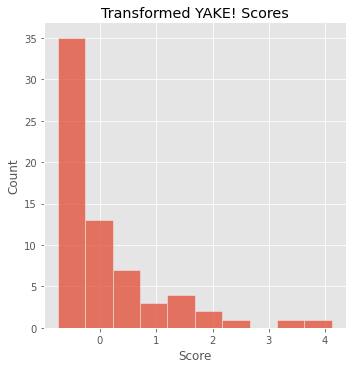

In [129]:
import seaborn as sns
sns.displot(yk_rank['Score']).set(title='Transformed YAKE! Scores')

### Kolmogorov Smirnov Test

In [165]:
from scipy.stats import kstest

In [173]:
kstest(rvs = yk_rank['Score'],
       cdf='powerlaw',
       args= [0.33]
      )

KstestResult(statistic=0.6417910447761194, pvalue=2.1759765005419565e-27)

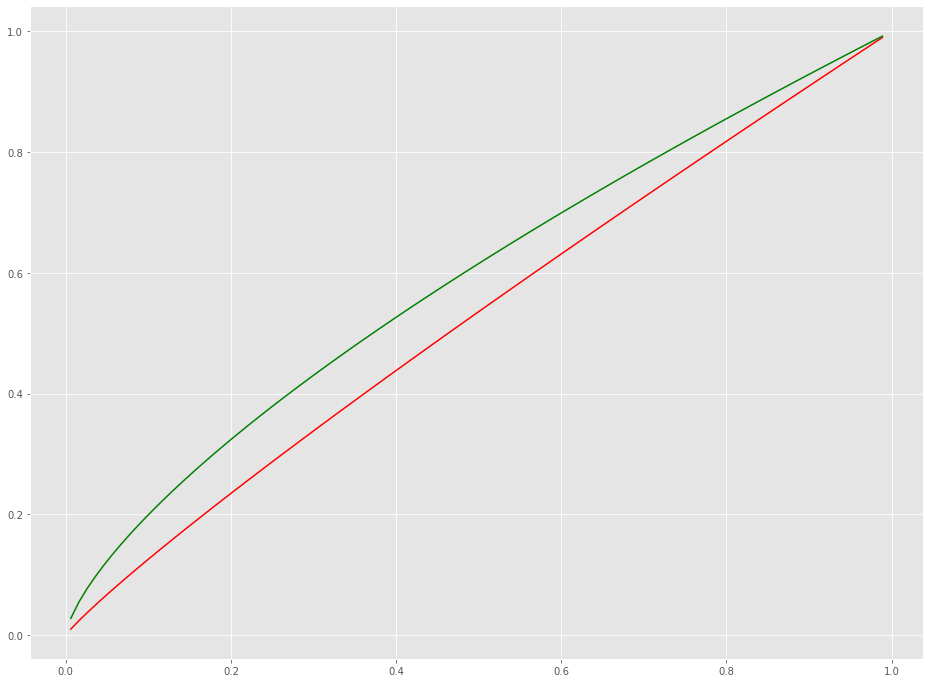

In [167]:
a_1 = 0.9

a_2 = 0.7

x = np.linspace(powerlaw.ppf(0.01,a),powerlaw.ppf(0.99,a),100)

plt.plot(x,powerlaw.cdf(x,a_1),'r')
plt.plot(x,powerlaw.cdf(x,a_2),'g')

##### Fitting powerlaw model to data

In [169]:
params = powerlaw.fit(data=yk_rank['Score'])

In [170]:
arg = params[:-2]
loc = params[-2]
scale = params[-1]

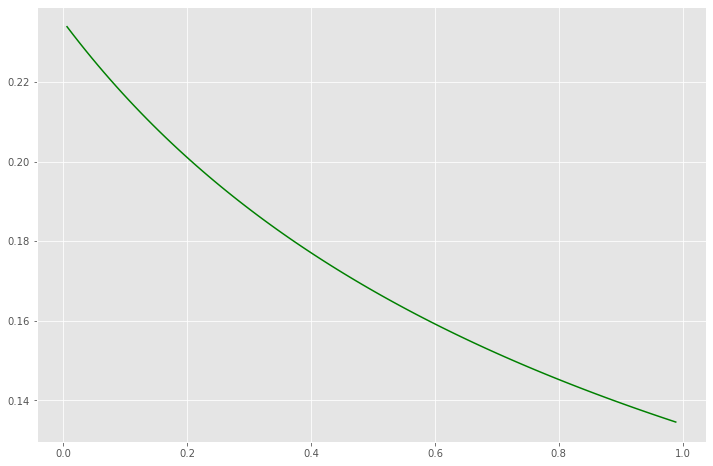

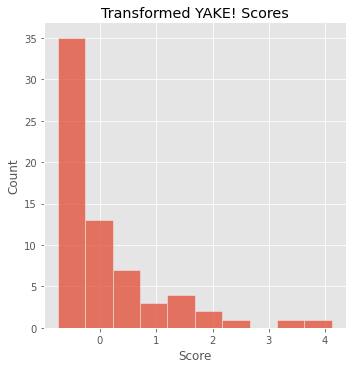

In [171]:
plt.figure(figsize=(12,8))
plt.plot(x,powerlaw.pdf(x,arg,loc,scale),'g')
sns.displot(yk_rank['Score']).set(title='Transformed YAKE! Scores')

In [172]:
arg

(0.33432292216446324,)

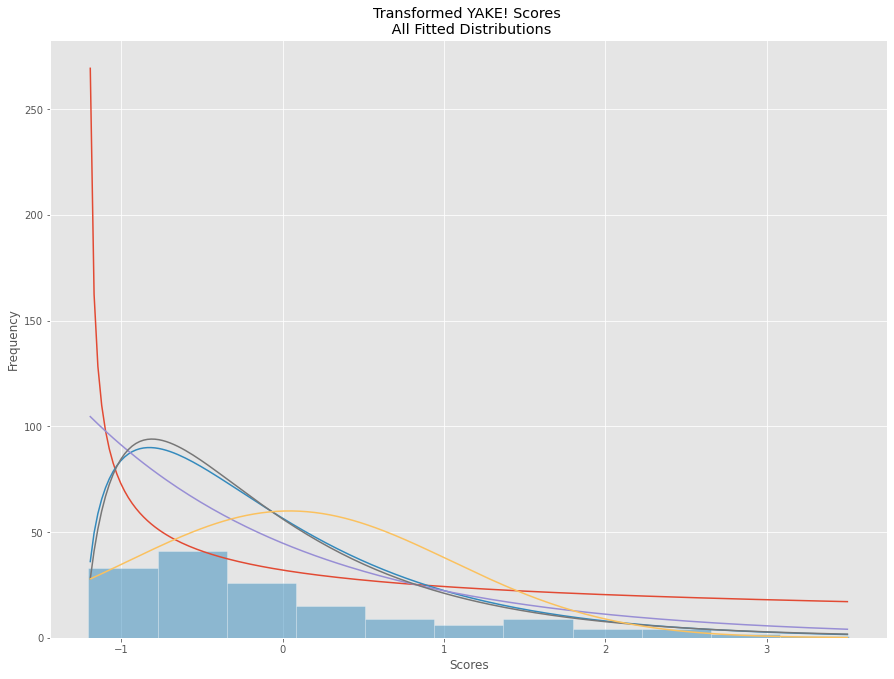

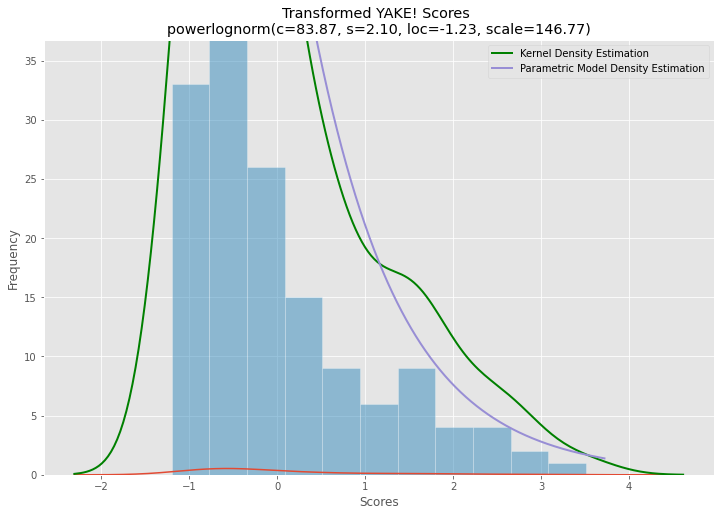

In [383]:
# Load data from statsmodels datasets
data = pd.Series(yk_rank['Score'])
bins = min(freedman_diaconis_rule(data),50)

# Plot for comparison
plt.figure(figsize=(15,11))
ax = data.plot(kind='hist', bins=bins, alpha=0.5,color=list(plt.rcParams['axes.prop_cycle'])[1]['color'],
              ec='white')

# Save plot limits


# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_title(u'Transformed YAKE! Scores \n All Fitted Distributions')
ax.set_xlabel(u'Scores')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display

plt.figure(figsize=(12,8))


p = sns.kdeplot(data)
kde = pd.Series(p.get_lines()[0].get_data()[1],p.get_lines()[0].get_data()[0])

plt.hist(data,alpha=0.5,bins=bins,ec='white')
plt.plot(kde*data.value_counts().sum(),lw=2, label='Kernel Density Estimation',color='g')
plt.plot(pdf*data.value_counts().sum(),lw=2, label='Parametric Model Density Estimation')

plt.ylim(plot.ax.get_ylim())

plt.ylabel('Count')
plt.xlabel('Scores')
plt.legend()

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

plt.title('Transformed YAKE! Scores \n' + dist_str)
plt.xlabel('Scores')
plt.ylabel('Frequency')

plt.legend()

In [413]:
best_fit_params

(83.86939991862597, 2.102024037830205, -1.229676654525639, 146.7736549938852)

In [418]:
kstest(rvs = yk_rank['Score'],
       cdf='powerlognorm',
       args= best_fit_params,
       alternative='two-sided'
      )

KstestResult(statistic=0.04380782225721469, pvalue=0.9234498885497779)

##### keyBERT

In [230]:
kb_rank = keybert_extraction(text=doc,
                keyphrases_ngram_max=2,
                n_top=100,
                transformers_model='distilbert-base-nli-mean-tokens',
                stopwords=None)

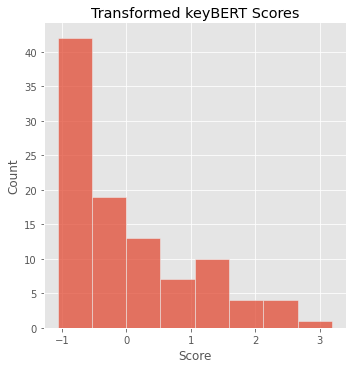

In [231]:
import seaborn as sns
sns.displot(kb_rank['Score']).set(title='Transformed keyBERT Scores')

### Kolmogorov Smirnov Test

In [232]:
from scipy.stats import kstest

In [233]:
kstest(rvs = kb_rank['Score'],
       cdf='powerlaw',
       args= [0.33]
      )

KstestResult(statistic=0.61, pvalue=2.966690864585136e-36)

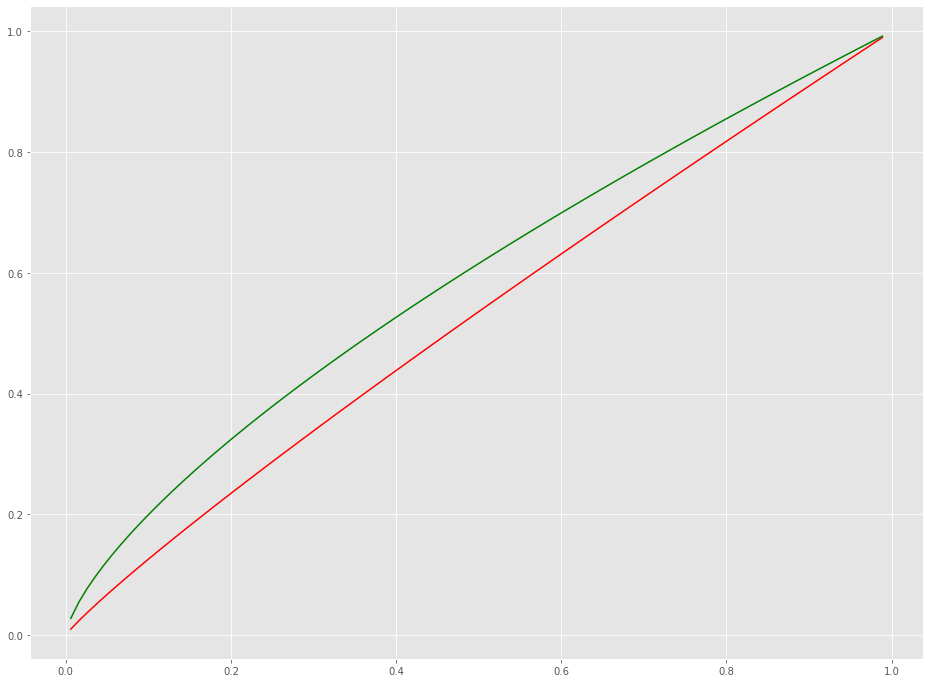

In [234]:
a_1 = 0.9

a_2 = 0.7

x = np.linspace(powerlaw.ppf(0.01,a),powerlaw.ppf(0.99,a),100)

plt.plot(x,powerlaw.cdf(x,a_1),'r')
plt.plot(x,powerlaw.cdf(x,a_2),'g')

##### Fitting powerlaw model to data

In [235]:
params = powerlaw.fit(data=kb_rank['Score'])

In [236]:
data = pd.Series(kb_rank['Score'])
arg = params[:-2]
loc = params[-2]
scale = params[-1]

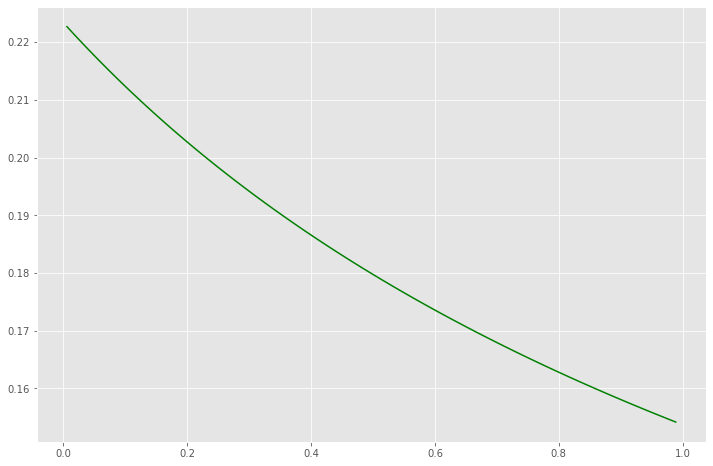

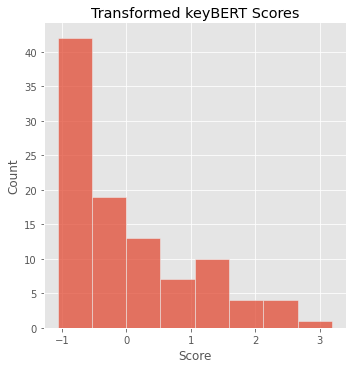

In [237]:
plt.figure(figsize=(12,8))
plt.plot(x,powerlaw.pdf(x,arg,loc,scale),'g')
sns.displot(kb_rank['Score']).set(title='Transformed keyBERT Scores')

In [238]:
arg

(0.43503769833605416,)

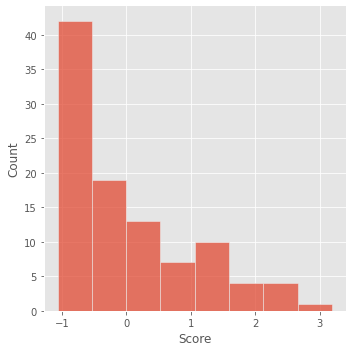

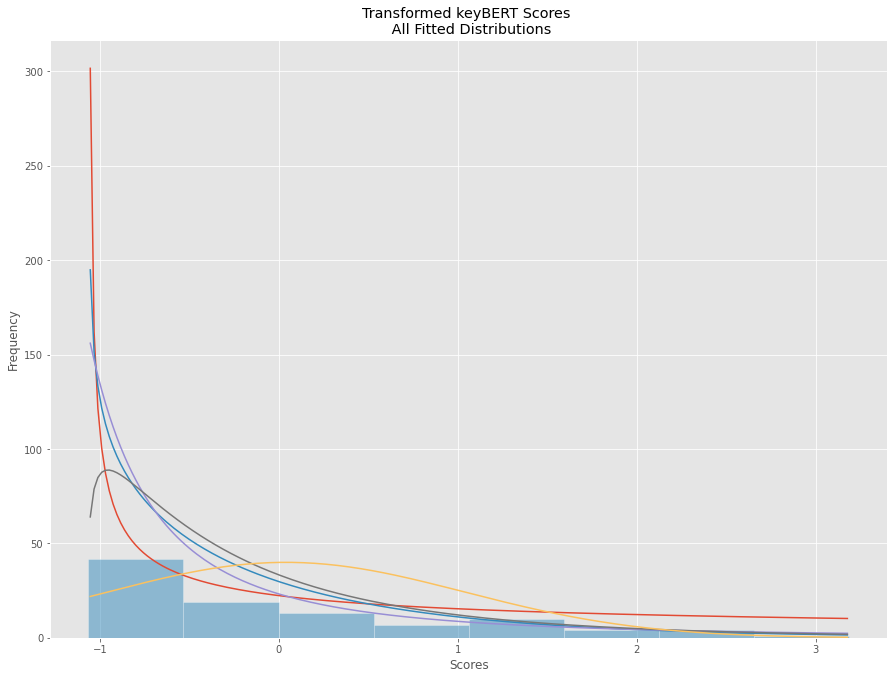

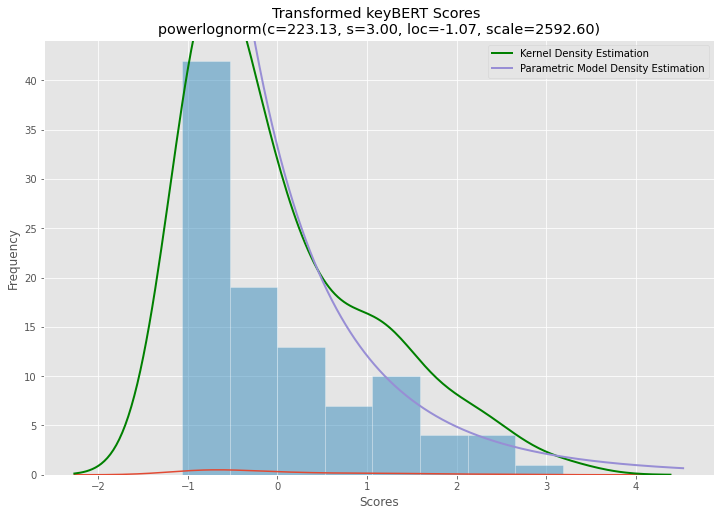

In [275]:
# Load data from statsmodels datasets
data = pd.Series(kb_rank['Score'])
p = sns.displot(data)
ylim_r = p.ax.get_ylim()

bins = min(freedman_diaconis_rule(data),50)

# Plot for comparison
plt.figure(figsize=(15,11))
ax = data.plot(kind='hist', bins=bins, alpha=0.5,color=list(plt.rcParams['axes.prop_cycle'])[1]['color'],
              ec='white')

# Save plot limits


# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_title(u'Transformed keyBERT Scores \n All Fitted Distributions')
ax.set_xlabel(u'Scores')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display

plt.figure(figsize=(12,8))


p = sns.kdeplot(data)
kde = pd.Series(p.get_lines()[0].get_data()[1],p.get_lines()[0].get_data()[0])

plt.hist(data,alpha=0.5,bins=bins,ec='white')
plt.plot(kde*data.value_counts().sum(),lw=2, label='Kernel Density Estimation',color='g')
plt.plot(pdf*data.value_counts().sum(),lw=2, label='Parametric Model Density Estimation')

plt.ylim(ylim_r)

plt.ylabel('Count')
plt.xlabel('Scores')
plt.legend()

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

plt.title('Transformed keyBERT Scores \n' + dist_str)
plt.xlabel('Scores')
plt.ylabel('Frequency')

plt.legend()

In [504]:
from scipy.stats import gamma

In [572]:
dist = powerlaw

In [605]:
# Separate parts of parameters
arg = 10000
loc = 0
scale = 1

# Get sane start and end points of distribution
start = dist.ppf(0.01, arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
end = dist.ppf(0.99, arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

In [606]:
arg

10000

In [607]:
x = np.linspace(start,end,100)

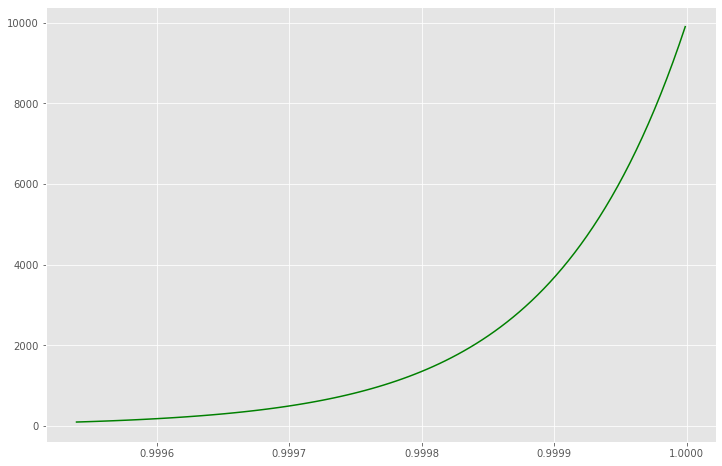

In [608]:
plt.figure(figsize=(12,8))
plt.plot(x,dist.pdf(x,arg,loc,scale),'g')

In [404]:
best_fit_params

(83.86939991862597, 2.102024037830205, -1.229676654525639, 146.7736549938852)

In [610]:
result = kstest(rvs = yk_rank['Score'],
       cdf='powerlognorm',
       args= best_fit_params
      )

In [614]:
_, p_value = result

In [615]:
p_value

0.9234498885497779

In [627]:
a = [4,5986,45,[5,6],0]

In [626]:
 [print(y) if type(x)== list else print(x) for y in x for x in a]

4
5986
45
0.9995395890030878
0
4
5986
45
0.999544229467369
0
4
5986
45
0.99954886993165
0
4
5986
45
0.9995535103959312
0
4
5986
45
0.9995581508602124
0
4
5986
45
0.9995627913244934
0
4
5986
45
0.9995674317887746
0
4
5986
45
0.9995720722530558
0
4
5986
45
0.9995767127173368
0
4
5986
45
0.999581353181618
0
4
5986
45
0.9995859936458991
0
4
5986
45
0.9995906341101802
0
4
5986
45
0.9995952745744614
0
4
5986
45
0.9995999150387425
0
4
5986
45
0.9996045555030236
0
4
5986
45
0.9996091959673048
0
4
5986
45
0.9996138364315859
0
4
5986
45
0.999618476895867
0
4
5986
45
0.9996231173601482
0
4
5986
45
0.9996277578244293
0
4
5986
45
0.9996323982887104
0
4
5986
45
0.9996370387529916
0
4
5986
45
0.9996416792172726
0
4
5986
45
0.9996463196815538
0
4
5986
45
0.999650960145835
0
4
5986
45
0.999655600610116
0
4
5986
45
0.9996602410743972
0
4
5986
45
0.9996648815386783
0
4
5986
45
0.9996695220029594
0
4
5986
45
0.9996741624672406
0
4
5986
45
0.9996788029315217
0
4
5986
45
0.9996834433958028
0
4
5986
45
0.999

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [635]:
args = list()
for x in a:
    if type(x)!=list:
        args.append(x)
    else:
        for t in x:
            args.append(t)
                

In [636]:
args

[4, 5986, 45, 5, 6, 0]

In [638]:
def pack_params(arg,loc,scale):
    params = list()
    a = [arg,loc,scale]
    
    for x in a:
        if type(x)!=list:
            params.append(x)
        else:
            for t in x:
                params.append(t)
    
    return params
    